## Важно:

Пожалуйста, поддерживайте ваш код в хорошем состоянии, пишите комментарии, убирайте бесполезные ячейки, пишите модели в специально отведенных модулях. Проверяющие могут **НА СВОЕ УСМОТРЕНИЕ** снижать баллы за:

1. Говнокод
2. Неэффективные решения
3. Вермишель из ячеек в тетрадке
4. Все остальное что им не понравилось

## Важно 2 (0 - 0.3 балла):

За использование логгеров типа wandb/comet/neptune и красивую сборку этой домашки в виде графиков/картинок в этих логгерах мы будем выдавать бонусные баллы. 

## Важно 3:

Решением домашки является архив с использованными тетрадками/модулями, а так же **.pdf файл** с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать модели которые вы использовали (например denoising AE или sparce AE в пункте 1)




In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
% matplotlib inline

В этом домашнем задании мы будем автоэнкодить Omniglot. Omniglot - это датасет в основном для few-shot learning'а, состоящий из рукописных символов из разных существующих и несуществующих (эльфийский, клингонский) языков.

В этом датасете очень много классов, для для каждого класса представлено только 10-20 картинок. Если учить честную классификацию, мы быстро столкнемся с тем, что модель не сможет нормально выучиться.

В этой тетрадке вам предлагается попробовать решить эту проблему - выучить автоэнкодер (любой формы) и, используя латентное его представление, делать классификацию более сложными методами на меньше размерности.

Omniglot очень странно построен, в нем background - это единицы, а не нули. Чтобы перевести это в удобный для нас формат - инвертируем каждый пиксель через нашу кастомную трансформацию - InvertImage


In [2]:
class InvertImage:
    def __call__(self, pic):
        return 1 - pic

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [3]:
from omniglot import FullOmniglot
from torchvision import transforms

from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    InvertImage(),
    #     transforms.Normalize([0.5], [0.5])
])

cuda_num = 0
device = f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu'
batch_size = 64


Мы используем кастомный датасет FullOmniglot потому что изначально train/val части омниглота использую разные классы. Мы обьединяем их и делаем свое разбиение

In [4]:
full_dataset = FullOmniglot('./Omniglot', transform=data_transforms, download=True)

labels = []
for _, label in full_dataset:
    labels.append(label)

# делаем так, чтобы сплит был сбалансированным по классам
indices_train, indices_test, _, _ = train_test_split(list(range(len(labels))), labels, test_size=0.1, stratify=labels)

train_dataset = Subset(full_dataset, indices=indices_train)
test_dataset = Subset(full_dataset, indices=indices_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
def process_image(image):
    return (image.squeeze().detach().to('cpu') + 1) / 2

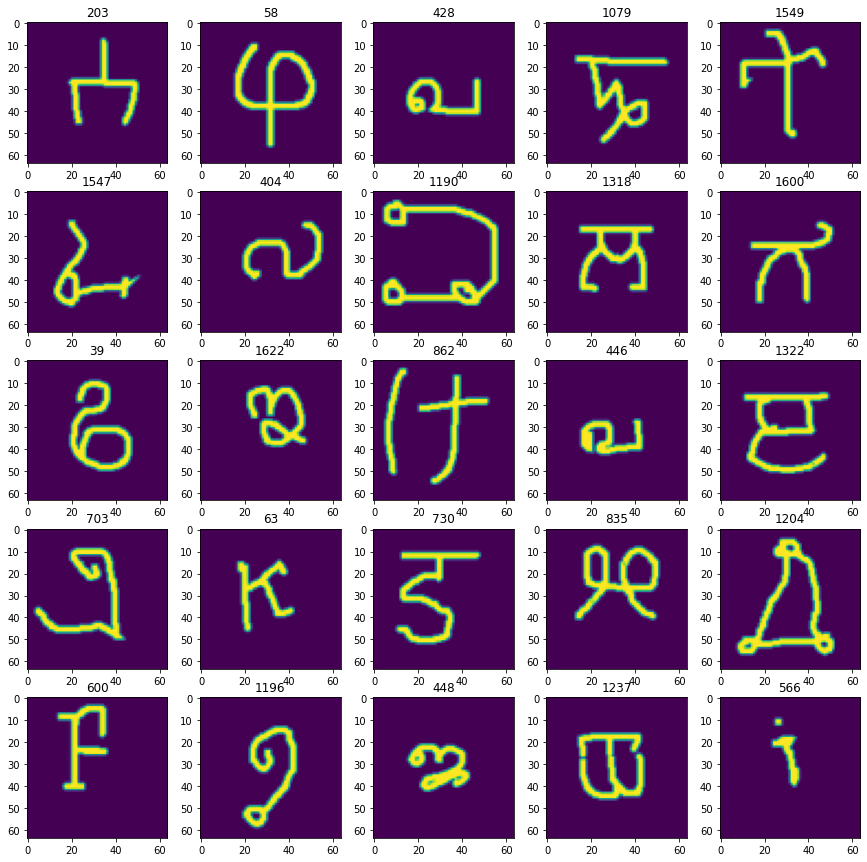

In [6]:
test_batch = next(iter(train_loader))

plt.figure(figsize=(15, 15))
for ind, (image, label) in enumerate(zip(*test_batch)):
    if ind >= 25: break
    plt.subplot(5, 5, ind + 1)
    plt.imshow(process_image(image))
    plt.title(label.item())
plt.show()


### Задача 1 (0.3 балла):

Написать свой автоэнкодер, доучить его до приличного качества

Для того чтобы писать красивый код и не делать тетрадку слишком длинной предлагается писать свои модели в отдельном модуле, см `./autoencoder.py`

In [7]:
from autoencoder import AutoEncoder


def prepare_input(x):
    return x + torch.randn_like(x) * 0.1


ae = AutoEncoder().to(device)
optim = torch.optim.Adam(ae.parameters(), lr=0.001)


Классический трейнлуп:

Note: я буду уважать вас сильнее если вместо вывода графика в тетрадку вы будете логгировать все (лоссы + картинки) в wandb/comet/neptune. И так далее по ходу тетрадки тоже

In [2]:
import wandb

wandb.init(project="DenoisingAE")

In [9]:
criterion = nn.MSELoss()
EPOCHS = 1
losses = []
ae.train()

for e in range(EPOCHS):
    for image, _ in tqdm(train_loader, desc='train loop', leave=True):
        optim.zero_grad()
        image = image.to(device)
        out = ae(prepare_input(image))
        loss = criterion(out, image)
        loss.backward()
        optim.step()
        wandb.log({'loss': loss.item()})

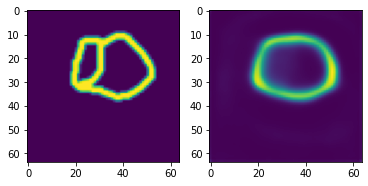

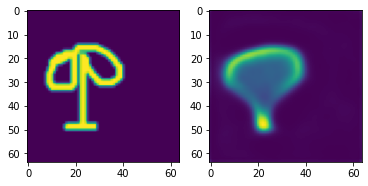

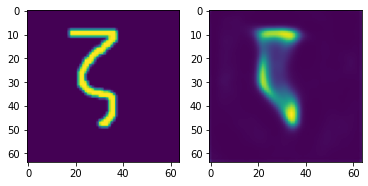

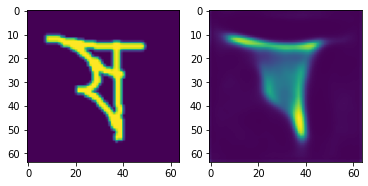

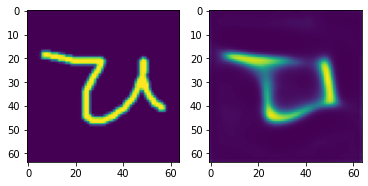

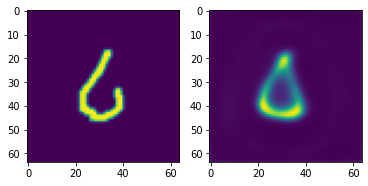

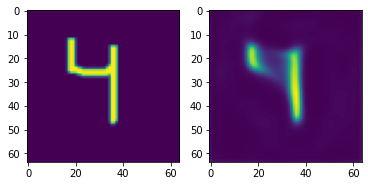

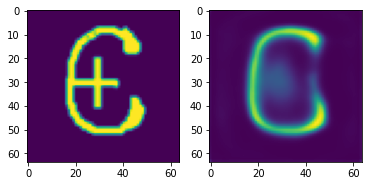

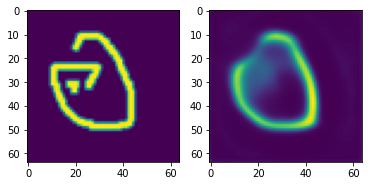

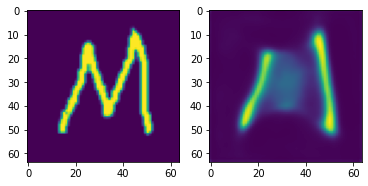

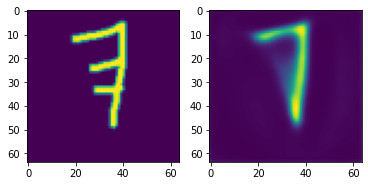

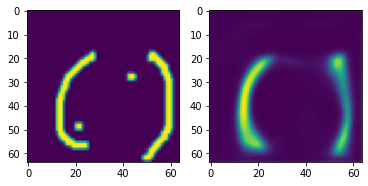

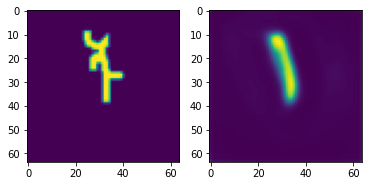

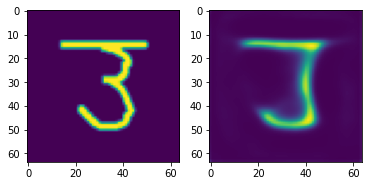

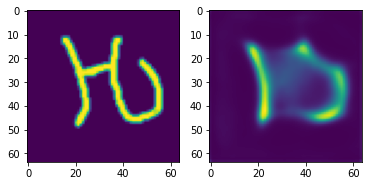

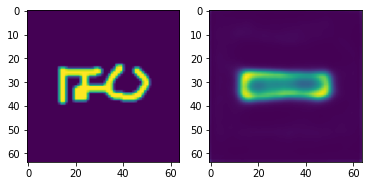

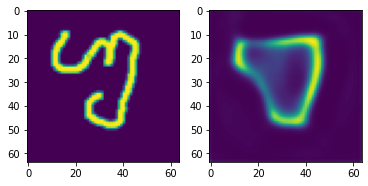

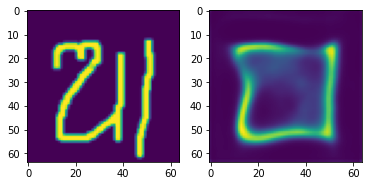

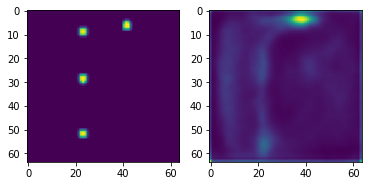

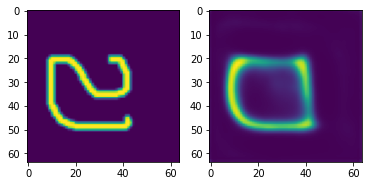

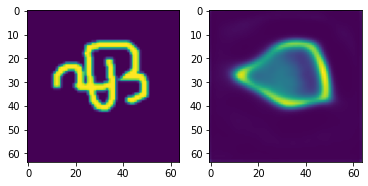

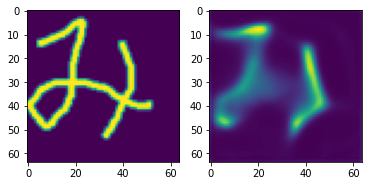

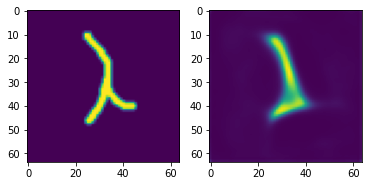

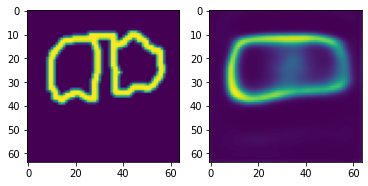

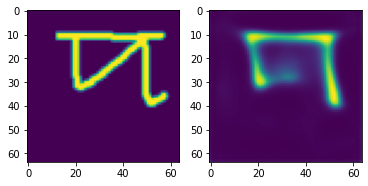

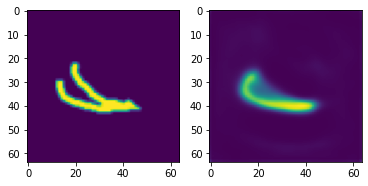

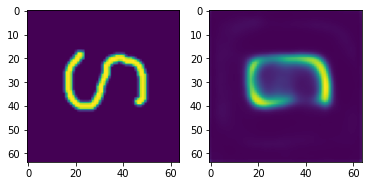

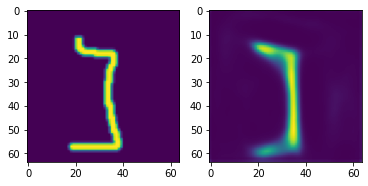

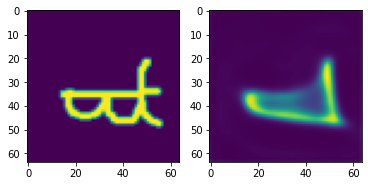

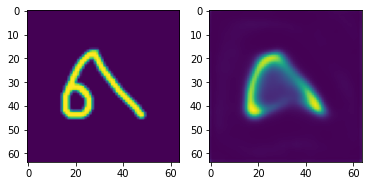

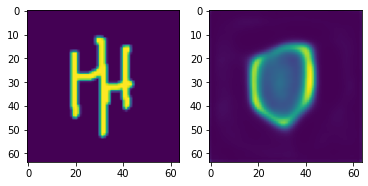

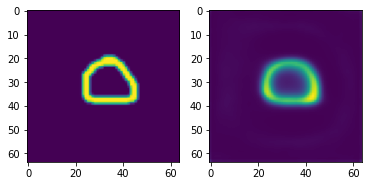

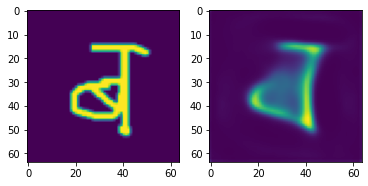

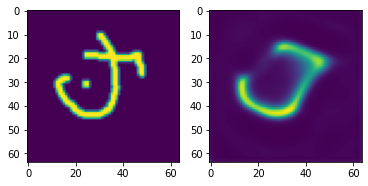

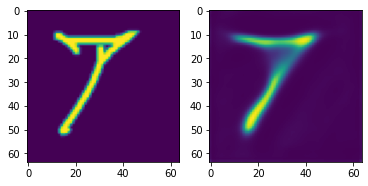

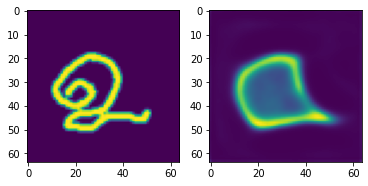

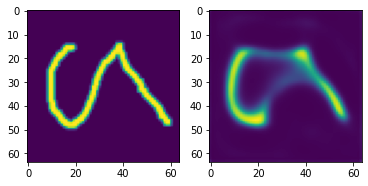

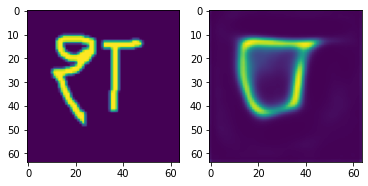

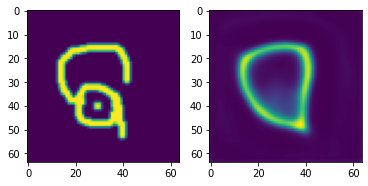

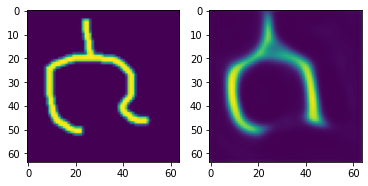

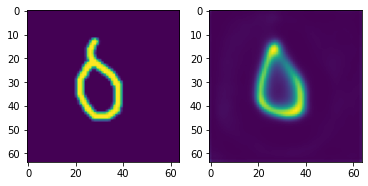

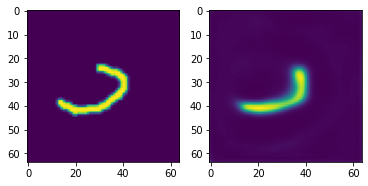

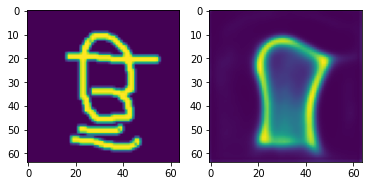

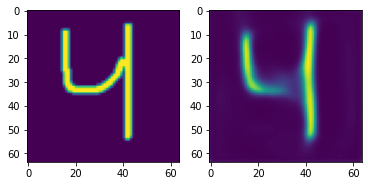

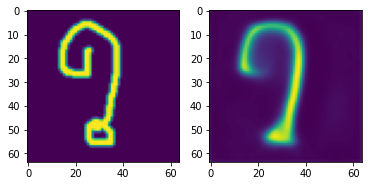

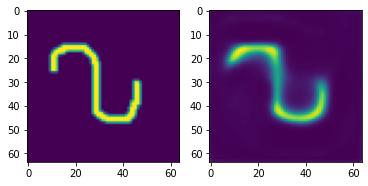

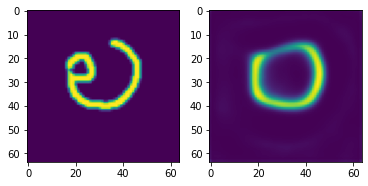

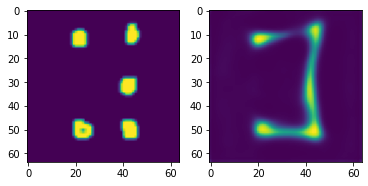

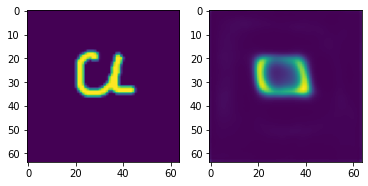

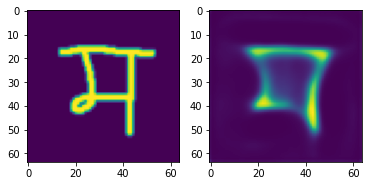

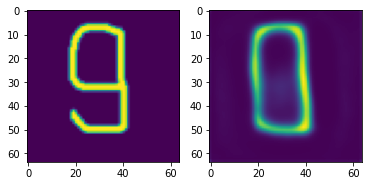

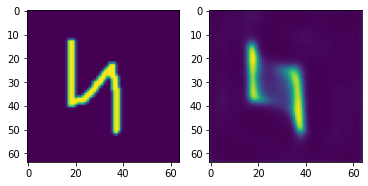

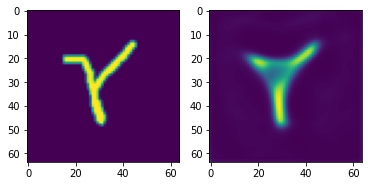

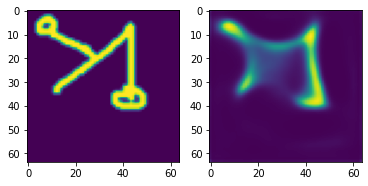

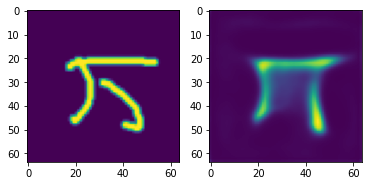

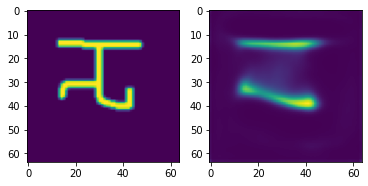

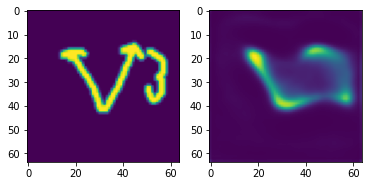

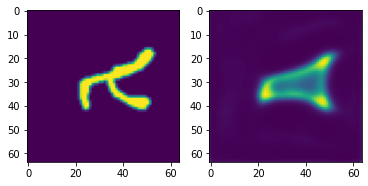

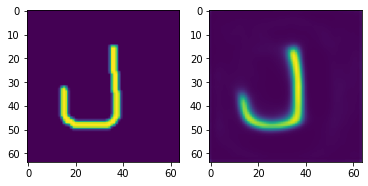

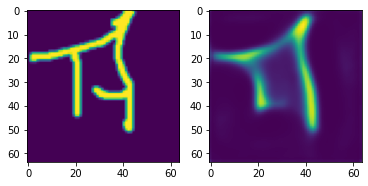

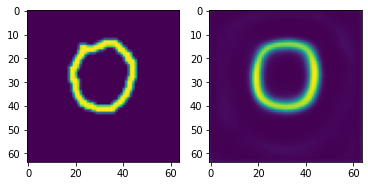

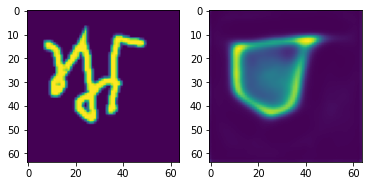

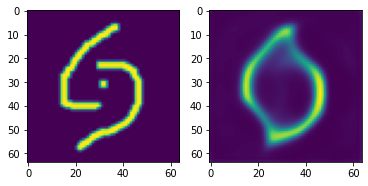

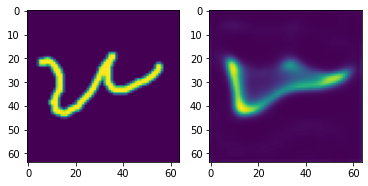

In [10]:
test_batch = next(iter(test_loader))
ae.eval()

for image in test_batch[0]:
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze())
    plt.subplot(1, 2, 2)
    plt.imshow(ae(image.unsqueeze(0).to(device)).squeeze().detach().to('cpu'))
    plt.show()


Мало посмотреть на результаты глазами, надо еще посчитать метрики качества.

Для этой задачи не очень хочется использовать FID с Inception обученными на ImageNet'е, поэтому предлагается обучить свою модель классификации на MNIST

Это можно сделать здесь (только красиво) или вынести в отдельную тетрадку/файлы

### Задача 2 (0.3 балла):

Научить внешний классификатор классифицировать MNIST, использовать его в подсчете FID между реальным Omniglot и выходами автоэнкодера

In [11]:
from torchvision.datasets import MNIST

mnist_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_dataset = MNIST('./MNIST', train=True, transform=data_transforms, download=True)
mnist_loader = DataLoader(mnist_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

In [13]:
from importlib import reload
import classifier

reload(classifier)
from classifier import Classifier

clf = Classifier().to(device)
optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

clf.train()

for image, label in tqdm(mnist_loader, desc='train loop', leave=True):
    optim.zero_grad()
    image = image.to(device)
    label = label.to(device)
    outputs = clf(image)

    loss = criterion(outputs, label)
    loss.backward()
    optim.step()
    wandb.log({'loss': loss.item()})

In [1]:
# import calculate_fid
# reload(calculate_fid)
# from calculate_fid import calculate_fid

# print(f"FID for AE: {calculate_fid(test_loader, ae, clf)}")

In [29]:
class NoiseRecoModel(nn.Module):
    def __init__(self, intensivity=0.1):
        super().__init__()
        # self.placeholder_layer
        # ненужный слой, который позвоняет в calculate_fid смотреть на каком девайсе расположена сетка
        self.placeholder_layer = nn.Linear(1, 1)
        self.intensivity = intensivity

    def forward(self, x):
        return x + torch.rand_like(x) * self.intensivity

Проверим насколько наша метрика стабильна: чем больше шум, тем больше она должна становиться

In [30]:
for noise_level in [0.001, 0.01, 0.05, 0.1, 0.5, 0.7, 1.]:
    noise_model = NoiseRecoModel(noise_level).to(device)
    print(f"FID for noise {noise_level}: {calculate_fid(test_loader, noise_model, clf)}")


fid loop:   1%|          | 3/456 [00:00<00:17, 25.99it/s]  

FID for noise 0.001: 3.7875207965498703e-06


fid loop:   1%|          | 3/456 [00:00<00:16, 27.17it/s]  

FID for noise 0.01: 0.00040438105176576755


fid loop:   0%|          | 2/456 [00:00<00:31, 14.33it/s]  

FID for noise 0.05: 0.01789473675992781


fid loop:   1%|          | 3/456 [00:00<00:17, 26.46it/s]  

FID for noise 0.1: 0.0908750491056054


fid loop:   1%|          | 3/456 [00:00<00:17, 25.29it/s]  

FID for noise 0.5: 3.3280764950685864


fid loop:   1%|          | 3/456 [00:00<00:17, 25.62it/s]  

FID for noise 0.7: 8.036847451198135


FID for noise 1.0: 18.675751518089136


Понятно что сам по себе автоэнкодер - такая себе генеративная модель, хоть ее и можно использовать в таком качестве

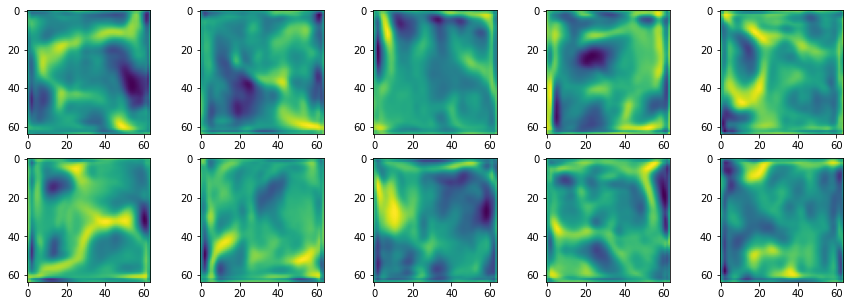

In [31]:
ae.eval()

test_images = next(iter(test_loader))[0].to(device)
images_latent = ae.get_latent_features(test_images).to('cpu')

test_noise = torch.randn_like(images_latent) * 0.9
sampled_mnist = ae.decoder(test_noise.to(device)).to('cpu')

plt.figure(figsize=(15, 5))
for ind in range(10):
    plt.subplot(2, 5, ind + 1)
    plt.imshow(sampled_mnist[ind].squeeze().detach())


Мы предлагаем использовать латентные фичи из AE для классификации.

Главная проблема классификации на Omniglot в том, что классов очень много и обычные классификаторы не могут справиться:

### Задача 3 (0.2 балла):

Попробовать честную классификацию на Omniglot, довести ее до приличного качества.

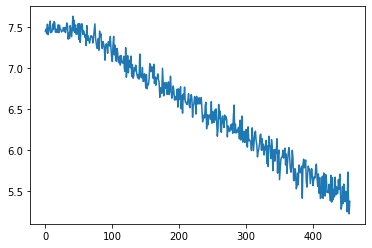

In [32]:
from classifier import Classifier

# clf = Classifier(*args?).to(device)
# optim = torch.optim.Adam(clf.parameters(), lr=0.001)

losses = []
clf.train()

for image, label in tqdm(train_loader, desc='train loop', leave=True):
# YOUR CODE
plt.plot(losses)
plt.show()

Посчитаем аккураси:

In [33]:
from sklearn.metrics import accuracy_score

true_labels = []
clf_predict_labels = []
clf.eval()

for image, label in tqdm(test_loader, desc='test clf loop', leave=True):
# YOUR CODE

true_labels = torch.cat(true_labels, dim=0).numpy()
clf_predict_labels = torch.cat(clf_predict_labels, dim=0).numpy()

In [35]:
print(f"random accuracy: {1 / 1623}")
print(f"CNN accuracy: {accuracy_score(true_labels, clf_predict_labels)}")

random accuracy: 0.0006161429451632779
CNN accuracy: 0.1103344298245614


Возможное решение проблемы с классификацией - обработка данный автоэнкодером и использование преобразованных латентных фичей вместо картинок.

Латентные фичи можно представить в виде табличных 1D данных, на которых можно учить даже разные бустинги.


### Задача 4 (0.2 балла):

Получить латентные представления от картинок в Omniglot, выучить любую (хорошую) модель классификации на них до адекватного качества.

note: не забывайте учить на трейне, а считать аккураси на тесте

In [ ]:
# YOUR CODE

In [46]:
pred = clf.predict(latent_test)

print(f"random accuracy: {1 / 1623}")
print(f"xgboost + AE accuracy: {accuracy_score(true_labels, pred)}")

random accuracy: 0.0006161429451632779
xgboost + AE accuracy: 0.7185032894736842
